# Building Demand Method 1 Simplified

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona

# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
# %matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [5]:
### Define directories and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"


In [6]:
## RWI layer
rwi_path = in_path + "/Residential/Data/WealthIndex"
rwi_name = 'zmb_relative_wealth_index.csv'

In [7]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Define area of interest

In [8]:
try: area
except NameError: area = "COUNTRY"
# area = "Copperbelt"

In [9]:
## Regions list
regions_path = "admin/"
regions_list = 'Regions_list.csv'
df_regions = pd.read_csv(regions_path + regions_list)
regions = df_regions['Regions GADM']
if area != "COUNTRY":
    regions = [area]
regions

0       Copperbelt
1         Muchinga
2    North-Western
3          Western
4          Luapula
5         Northern
6          Central
7         Southern
8          Eastern
9           Lusaka
Name: Regions GADM, dtype: object

### Import layers to be used

In [10]:
## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "/" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

In [11]:
hexagons = gpd.read_file(out_path + "\\" + "h3_grid_at_hex_7.shp")

In [12]:
grid = hexagons

In [13]:
grid

,hexagons,lon,lat,index_righ,NAME_1,id,geometry
0,8755a5318ffffff,24.24,-16.63,9.00,Western,1,"POLYGON ((24.25439 -16.63633, 24.24407 -16.645..."
1,873980648ffffff,31.56,-8.83,7.00,Northern,2,"POLYGON ((31.57429 -8.83211, 31.56467 -8.84303..."
2,8755ac054ffffff,22.59,-16.09,9.00,Western,3,"POLYGON ((22.60573 -16.09723, 22.59554 -16.106..."
3,87399e8a9ffffff,29.19,-9.25,3.00,Luapula,4,"POLYGON ((29.20019 -9.25349, 29.19050 -9.26410..."
4,875530676ffffff,26.36,-13.19,6.00,North-Western,5,"POLYGON ((26.37327 -13.19218, 26.36319 -13.202..."
...,...,...,...,...,...,...,...
122983,8739b6140ffffff,31.84,-14.05,2.00,Eastern,122984,"POLYGON ((31.85483 -14.05221, 31.84461 -14.062..."
122984,875510284ffffff,23.77,-14.68,9.00,Western,122985,"POLYGON ((23.78490 -14.68824, 23.77477 -14.697..."
122985,8755a1572ffffff,23.47,-17.46,9.00,Western,122986,"POLYGON ((23.48378 -17.46457, 23.47343 -17.474..."
122986,875506a85ffffff,24.87,-12.06,6.00,North-Western,122987,"POLYGON ((24.87932 -12.06839, 24.86940 -12.078..."


## Extract raster values to hexagons

Extract count of buildings per hex from WorldPop

In [14]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/ZMB_buildings_v2_0_count.tif"
# grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)
grid = processing_raster("buildings", "sum", grid, filepath=pathWorldPopBuiCount) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/
# pathWorldPopBuiArea = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_total_area.tif"
# grid = processing_raster("bui_area_WP", "sum", grid, filepath=pathWorldPopBuiArea) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2024-01-28 00:47:33.972956


Extract urban areas from WorldPop

In [15]:
pathWorldPopBuiUrban = "Residential/Data/WorldPop/ZMB_buildings_v2_0_urban.tif"
grid = processing_raster("locationWP", "median", grid, filepath=pathWorldPopBuiUrban)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2024-01-28 00:56:05.197179


Extract lighing data

In [16]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
# pathHREA = "Residential/Data/Lighting/Copperbelt_set_lightscore_sy_2019_Nodata_values_fixed.tif"
pathHREA = "Residential/Data/Lighting/Zambia_set_lightscore_sy_2019.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
columnProbElec= "HREA"

2024-01-28 13:32:36.701120


Extract RWI

In [17]:
# Relative Wealth Index (RWI) -- extracting the mean value per building
# Link: https://gee-community-catalog.org/projects/rwi/
pathRWI = "Residential/Data/WealthIndex/rwi_map.tif"
grid = processing_raster("rwi", "mean", grid, filepath=pathRWI)
print(grid)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



##### Once done with rasters run this cell

In [18]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2024-01-28 13:40:44.240366


In [19]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)
grid.rename({'rwimean': 'rwi'}, axis=1, inplace=True)
grid.rename({'locationWPmedian': 'locationWP'}, axis=1, inplace=True)

Add values in RWI column when there is none

In [20]:
grid["rwi"].fillna(grid["rwi"].mean(numeric_only=True).round(1), inplace=True)
print(grid["rwi"].min())
print(grid["rwi"].max())

-1.2319999933242798
1.496250033378601


In [21]:
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,geometry
0,8755a5318ffffff,24.24,-16.63,9.00,Western,1,9.00,0.00,0.03,-0.40,"POLYGON ((24.25439 -16.63633, 24.24407 -16.645..."
1,873980648ffffff,31.56,-8.83,7.00,Northern,2,44.00,0.00,0.04,-0.23,"POLYGON ((31.57429 -8.83211, 31.56467 -8.84303..."
2,8755ac054ffffff,22.59,-16.09,9.00,Western,3,NaN,NaN,0.00,-0.40,"POLYGON ((22.60573 -16.09723, 22.59554 -16.106..."


## Compute residential demand

### Step 1: assess the number of HH with access

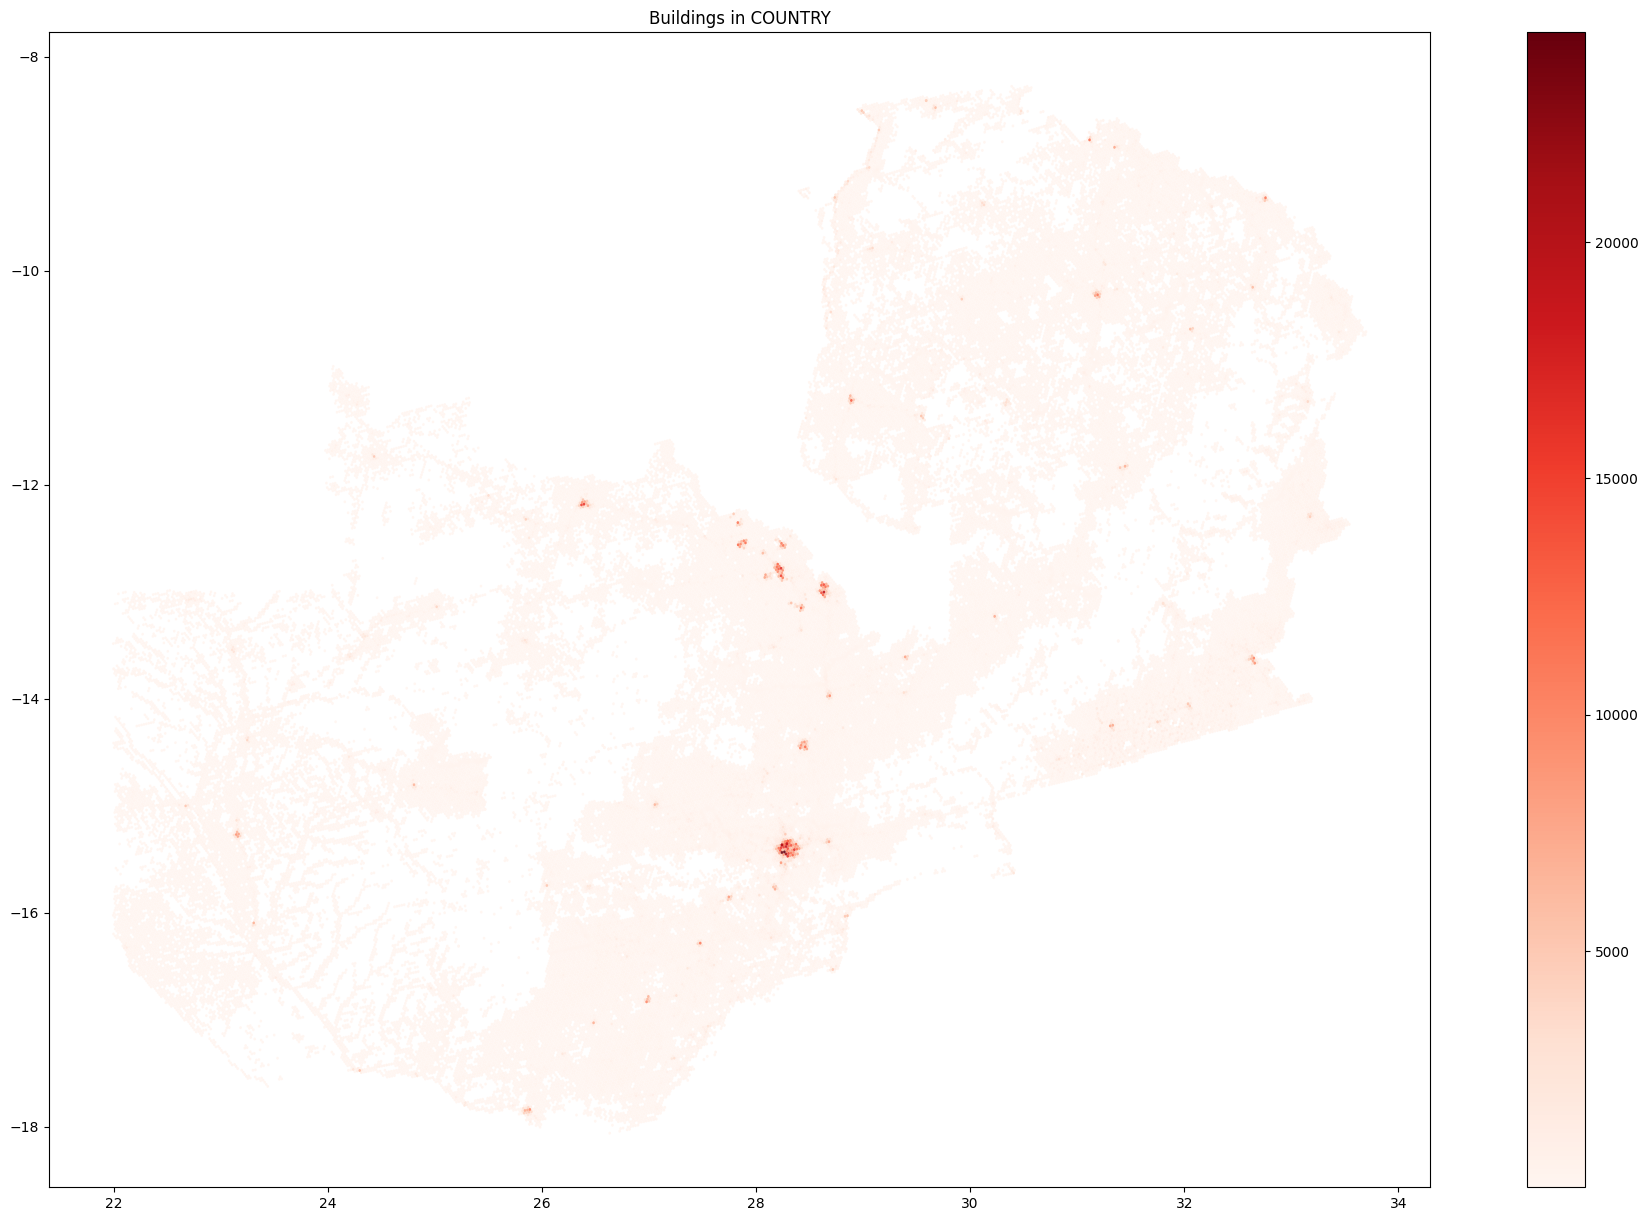

In [22]:
# Plot the buildings map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('buildingssum', ascending=True).plot(
    ax=ax, column='buildingssum', cmap="Reds", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Buildings in {}'.format(area) )

# # Save plot as figure 
# plt.savefig('sample_priority_map.png', bbox_inches='tight')

Determine electrifed status of each cell

In [179]:
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row[columnProbElec] > 0.25))
                                             else "nonelec"), axis=1)
grid["Status_electrified"].value_counts()

Status_electrified
nonelec    109649
elec        13339
Name: count, dtype: int64

Determine location (ruban or rural) of each cell

In [180]:
# for each hexagon, determine if it's rural or urban --> choose best source
# grid["locAssessed"] = grid.apply(lambda row: ("urban" if ((row['buildingssum'] > 1000)) # number chosen to get 1 for nb of HH per rural building
#                                              else "rural"), axis=1)
grid["locWorldPop"] = grid.apply(lambda row: ("urban" if ((row['locationWP'] == 1)) 
                                             else "rural"), axis=1)
# grid["locGHSL"] = grid.apply (lambda row: ("urban" if ((row['SMOD'] == 30) or (row['SMOD'] == 21) or (row['SMOD'] == 22) or (row['SMOD' ] == 23)) 
#                                              else "rural"), axis=1)
grid["location"] = grid["locWorldPop"] 

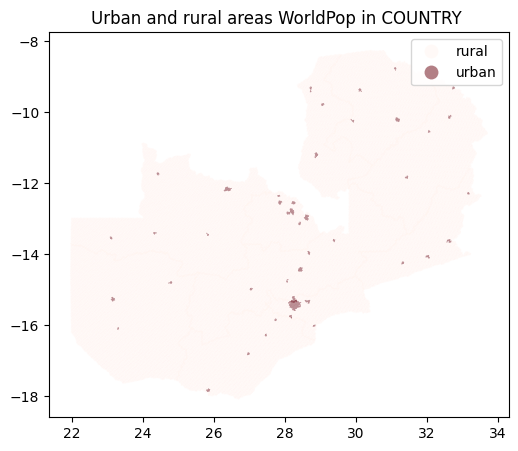

In [181]:
# map of the urban and rural areas WorldPop
# Create the axis first
fig2, ax2 = plt.subplots(figsize=(10, 5))
# Plot
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=ax2, column='locWorldPop', cmap="Reds", legend=True, alpha=0.5)

ax2.set_aspect('equal', 'box')
txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format(area))

Assess number of residential households per cell

In [182]:
# Load data into Pandas DataFrame
## Census data
data_path = "Residential/Data/"
census_name = 'Census_Zambia.csv'
df_censusdata = pd.read_csv(data_path + census_name)

# Create a new dataframe that will contain the regional data
data_HH = df_censusdata[['Region', 'Urban', 'Rural']]
data_HH = data_HH.rename({'Region':'region','Urban':'HH_urban', 'Rural':'HH_rural'}, axis = 1)
data_HH = data_HH.set_index(['region'])
data_HH['HH_total'] = data_HH['HH_urban'] + data_HH['HH_rural']
data_HH = data_HH.astype(float)

In [183]:
# Option 1: use buildings count from Worldpop to assess number of buildings
# total number of buildings
data_buildings = []
for region in regions:
    totalBuildings = grid[(grid['NAME_1'] == region)]['buildingssum'].sum()
    urbanBuildings = grid[(grid['location'] == "urban") & (grid['NAME_1'] == region)]['buildingssum'].sum()
    ruralBuildings = grid[(grid['location'] == "rural") & (grid['NAME_1'] == region)]['buildingssum'].sum()
    data_region = {
        'region': region,
        'totalBuildings': totalBuildings,
        'urbanBuildings': urbanBuildings,
        'ruralBuildings': ruralBuildings,
        'shareRuralBuild': ruralBuildings / totalBuildings,
        'shareUrbanBuild': urbanBuildings / totalBuildings,
    }
    data_buildings.append(data_region)
    # print("total Buildings in",f"{region}",f"{totalBuildings:,.0f}", "urban:",f"{urbanBuildings:,.0f}", "rural:",f"{ruralBuildings:,.0f}")
    # print("share Build urban:", f"{data_region['shareUrbanBuild']:.0%}","rural:",f"{data_region['shareRuralBuild']:.0%}")

df_buildings = pd.DataFrame(data_buildings)
df_buildings = df_buildings.set_index('region')
# df_buildings
df_HH_buildings = data_HH.merge(df_buildings, left_on='region', right_on='region')
df_HH_buildings

,HH_urban,HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild
region,,,,,,,,
Copperbelt,"449,077.00","85,356.00","534,433.00","1,117,170.00","604,165.00","513,005.00",0.46,0.54
Muchinga,"24,953.00","151,730.00","176,683.00","623,493.00","80,335.00","543,158.00",0.87,0.13
North-Western,"91,501.00","116,233.00","207,734.00","576,163.00","151,021.00","425,142.00",0.74,0.26
Western,"54,466.00","205,604.00","260,070.00","796,764.00","80,858.00","715,906.00",0.90,0.10
Luapula,"44,689.00","228,300.00","272,989.00","615,968.00","84,579.00","531,389.00",0.86,0.14
Northern,"72,867.00","230,684.00","303,551.00","823,956.00","104,365.00","719,591.00",0.87,0.13
Central,"98,493.00","292,947.00","391,440.00","1,533,577.00","321,668.00","1,211,909.00",0.79,0.21
Southern,"120,410.00","316,294.00","436,704.00","1,359,567.00","132,997.00","1,226,570.00",0.90,0.10
Eastern,"82,166.00","369,725.00","451,891.00","1,359,153.00","119,052.00","1,240,101.00",0.91,0.09


In [184]:
# Assess number of residential buildings

# share of residential building in each location --> not used because we use the assumption of nb of HH per res bui
# shareResBuildings = {"urban": 0.5, "rural": 0.15} # --> to change! # number chosen to get 1 for nb of HH per rural building, and for urban twice the value in rural
# resUrbanBuildings = urbanBuildings*shareResBuildings["urban"]
# resRuralBuildings = ruralBuildings*shareResBuildings["rural"]
# resTotalBuildings = resUrbanBuildings + resRuralBuildings

# Assess the number of residential HH per building
nbOfHHperResBuilding =  {"urban": 1.2, "rural": 1}  # --> to change!
# nbOfHHperResBuilding["urban"]= HH_urban/resUrbanBuildings --> use if the main assumption is on the share of res buildings
# nbOfHHperResBuilding["rural"]= HH_rural/resRuralBuildings --> use if the main assumption is on the share of res buildings

# Assess the number of residential buildings
df_HH_buildings['shareUrbanResBui'] = df_HH_buildings['HH_urban'] /(nbOfHHperResBuilding["urban"]* df_HH_buildings['urbanBuildings'])
df_HH_buildings['shareRuralResBui'] = df_HH_buildings['HH_rural'] /(nbOfHHperResBuilding["rural"]* df_HH_buildings['ruralBuildings'])
df_HH_buildings['resUrbanBui'] = df_HH_buildings['urbanBuildings'] * df_HH_buildings['shareUrbanResBui']
df_HH_buildings['resRuralBui'] = df_HH_buildings['ruralBuildings'] * df_HH_buildings['shareRuralResBui']
df_HH_buildings['resTotalBui'] = df_HH_buildings['resUrbanBui'] + df_HH_buildings['resRuralBui']

# Check: Assess the total number of HH in the region (should match the census data)
totalResHHurban = nbOfHHperResBuilding["urban"]*df_HH_buildings['resUrbanBui']
# print(totalResHHurban)
# print(df_HH_buildings['HH_urban'])
# assert totalResHHurban.equals(df_HH_buildings['HH_urban'])
totalResHHrural = nbOfHHperResBuilding["rural"]*df_HH_buildings['resRuralBui']
# assert totalResHHrural.equals(df_HH_buildings['HH_rural'])

# Number of HH per res buildings in each region average
df_HH_buildings['nbOfHHperResBui_average'] = df_HH_buildings['HH_total'] / (df_HH_buildings['urbanBuildings']*df_HH_buildings['shareUrbanResBui'] +
                                                                 df_HH_buildings['ruralBuildings'] * df_HH_buildings['shareRuralResBui'])

df_HH_buildings

,HH_urban,HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild,shareUrbanResBui,shareRuralResBui,resUrbanBui,resRuralBui,resTotalBui,nbOfHHperResBui_average
region,,,,,,,,,,,,,,
Copperbelt,"449,077.00","85,356.00","534,433.00","1,117,170.00","604,165.00","513,005.00",0.46,0.54,0.62,0.17,"374,230.83","85,356.00","459,586.83",1.16
Muchinga,"24,953.00","151,730.00","176,683.00","623,493.00","80,335.00","543,158.00",0.87,0.13,0.26,0.28,"20,794.17","151,730.00","172,524.17",1.02
North-Western,"91,501.00","116,233.00","207,734.00","576,163.00","151,021.00","425,142.00",0.74,0.26,0.50,0.27,"76,250.83","116,233.00","192,483.83",1.08
Western,"54,466.00","205,604.00","260,070.00","796,764.00","80,858.00","715,906.00",0.90,0.10,0.56,0.29,"45,388.33","205,604.00","250,992.33",1.04
Luapula,"44,689.00","228,300.00","272,989.00","615,968.00","84,579.00","531,389.00",0.86,0.14,0.44,0.43,"37,240.83","228,300.00","265,540.83",1.03
Northern,"72,867.00","230,684.00","303,551.00","823,956.00","104,365.00","719,591.00",0.87,0.13,0.58,0.32,"60,722.50","230,684.00","291,406.50",1.04
Central,"98,493.00","292,947.00","391,440.00","1,533,577.00","321,668.00","1,211,909.00",0.79,0.21,0.26,0.24,"82,077.50","292,947.00","375,024.50",1.04
Southern,"120,410.00","316,294.00","436,704.00","1,359,567.00","132,997.00","1,226,570.00",0.90,0.10,0.75,0.26,"100,341.67","316,294.00","416,635.67",1.05
Eastern,"82,166.00","369,725.00","451,891.00","1,359,153.00","119,052.00","1,240,101.00",0.91,0.09,0.58,0.30,"68,471.67","369,725.00","438,196.67",1.03


In [185]:
# Assess the number of HH per cell
grid['res_urbanBui'] = grid['buildingssum'] * (grid['location'] == 'urban') * grid['NAME_1'].map(df_HH_buildings['shareUrbanResBui'])
grid['res_ruralBui'] = grid['buildingssum'] * (grid['location'] == 'rural') * grid['NAME_1'].map(df_HH_buildings['shareRuralResBui'])
grid['res_Bui'] = grid['res_urbanBui'] + grid['res_ruralBui']
grid['HH_urban'] = grid['res_urbanBui'] * nbOfHHperResBuilding['urban']
grid['HH_rural'] = grid['res_ruralBui'] * nbOfHHperResBuilding['rural']

Assess number of residential households per cell with access to electricity

In [186]:
# for each hexagon, assessment of the number of HH with access
# access_elec = {"elec": 0, "nonelec": 1}
# sizeHH = {"urban": 4.7, "rural": 5.2} #https://population.un.org/Household/index.html#/countries/ https://dhsprogram.com/publications/publication-fr361-dhs-final-reports.cfm
#grid["HHwithAccess"]=grid["buildingscount"]*grid["Location"].map(shareResBuildings)*grid["Status_electrified"].map(access_elec)
grid["HHwithAccess_urb"] = grid['HH_urban'] * grid[columnProbElec]
grid["HHwithAccess_rur"] = grid['HH_rural'] * grid[columnProbElec]                                        
# grid["HHwithAccess_urb"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "urban"), grid[['buildingssum']].sum(axis=1), 0) * grid['NAME_1'].map(shareUrbanResBuildings) * nbOfHHperResBuilding["urban"] * grid[columnProbElec]                                        
# grid["HHwithAccess_rur"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "rural"), grid[['buildingssum']].sum(axis=1), 0) * grid['NAME_1'].map(shareRuralResBuildings) * nbOfHHperResBuilding["rural"] * grid[columnProbElec]
grid["HHwithAccess"] = grid["HHwithAccess_urb"] + grid["HHwithAccess_rur"]

grid['HHwoAccess_urb'] = grid['HH_urban'] - grid['HHwithAccess_urb']
grid['HHwoAccess_rur'] = grid['HH_rural'] - grid['HHwithAccess_rur']
grid['HHwoAccess'] = grid['HHwoAccess_urb'] + grid['HHwoAccess_rur']

totalResHHWithAccessUrb = grid.groupby('NAME_1')['HHwithAccess_urb'].sum()
totalResHHWithAccessRur = grid.groupby('NAME_1')['HHwithAccess_rur'].sum()
totalResHHWithAccess = grid.groupby('NAME_1')['HHwithAccess'].sum()

print("total number of HH with Access in:")
for region in regions:
    print(f"{region}",":", f"{totalResHHWithAccessUrb[region]:,.0f}")
    print("rural:",f"{totalResHHWithAccessRur[region]:,.0f}")
    print("urban:",f"{totalResHHWithAccess[region]:,.0f}")
# print(grid["HHwithAccess_urb"].sum() , grid["HHwithAccess_rur"].sum(), grid["HHwithAccess"].sum())
grid.head(2)

total number of HH with Access in:
Copperbelt : 449,039
rural: 47,967
urban: 497,006
Muchinga : 24,106
rural: 26,797
urban: 50,904
North-Western : 85,893
rural: 26,517
urban: 112,410
Western : 52,925
rural: 34,548
urban: 87,472
Luapula : 42,626
rural: 80,023
urban: 122,649
Northern : 69,798
rural: 49,049
urban: 118,847
Central : 97,553
rural: 72,684
urban: 170,237
Southern : 120,120
rural: 71,579
urban: 191,699
Eastern : 79,746
rural: 66,117
urban: 145,863
Lusaka : 522,715
rural: 50,859
urban: 573,573


,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,ResEnergy_kWh,REnS_kWh,serBui,serBUi_Acc,SEn_kWh,HHwoAccess_urb,HHwoAccess_rur,res_urbanBui,res_ruralBui,res_Bui
0,8755a5318ffffff,24.24,-16.63,9.00,Western,1,9.00,0.00,0.03,-0.40,...,0.27,0.43,3.95,0.13,47.35,0.00,2.50,0.00,2.58,2.58
1,873980648ffffff,31.56,-8.83,7.00,Northern,2,44.00,0.00,0.04,-0.23,...,2.20,2.90,18.40,0.76,271.27,0.00,13.52,0.00,14.11,14.11


Compute the resulting access rate

In [187]:
# access rate for HH
accessRateHH={}
accessRateHH_urban={}
accessRateHH_rural={}
print("HH access rate:")
for region in regions:
    accessRateHH[region] = totalResHHWithAccess[region]/df_HH_buildings.loc[region, 'HH_total']
    accessRateHH_urban[region] = totalResHHWithAccessUrb[region]/totalResHHurban[region]
    accessRateHH_rural[region] = totalResHHWithAccessRur[region]/totalResHHrural[region]
    print(f"{region}",f"{accessRateHH[region]:,.0%}")
    print("urban:",f"{accessRateHH_urban[region]:,.0%}")
    print("rural:",f"{accessRateHH_rural[region]:,.0%}")
# access rate for population
# accessRatePop = (totalResHHWithAccessUrb*pplperHH_urban+totalResHHWithAccessRur*pplperHH_rural)/totalPopStats
# accessRatePop_urban = totalResHHWithAccessUrb*pplperHH_urban/totalPop_urban
# accessRatePop_rural = totalResHHWithAccessRur*pplperHH_rural/totalPop_rural
# print("Pop access rate :",f"{accessRatePop:,.0%}")
# print("Pop access rate urban:",f"{accessRatePop_urban:,.0%}")
# print("Pop access rate rural:",f"{accessRatePop_rural:,.0%}")

HH access rate:
Copperbelt 93%
urban: 100%
rural: 56%
Muchinga 29%
urban: 97%
rural: 18%
North-Western 54%
urban: 94%
rural: 23%
Western 34%
urban: 97%
rural: 17%
Luapula 45%
urban: 95%
rural: 35%
Northern 39%
urban: 96%
rural: 21%
Central 43%
urban: 99%
rural: 25%
Southern 44%
urban: 100%
rural: 23%
Eastern 32%
urban: 97%
rural: 18%
Lusaka 91%
urban: 100%
rural: 47%


### Step 2: assess the energy consumption per HH

In [188]:
# # Retrieve values from the MTF survey # not used because it leads to an overassessment of energy
# %run Residential/energy_demand_res.ipynb
# energyConsHH = energycons_res_mtf["annual"] # dictionnary for each region one value
# energyConsHH['COPPERBELT']=1250
# energyConsHH

In [189]:
# function for allocate tier of energy consumption to an index
def index_to_energy(index, table_index):
    energy = 0
    for key, val in table_index:
        if index < key:
            break
        else: energy = val
    return energy

# data for energy consumption tiers
file_HHenergycons = "HH_energyconsumption.csv"
HHenergycons = pd.read_csv(data_path + file_HHenergycons)
thresholds_energy = HHenergycons.iloc[0].tolist() # thresholds_energy  = [5, 73, 365, 1250, 3012]
print(HHenergycons)

   Tier 1  Tier 2  Tier 3  Tier 4  Tier 5
0       5      73     365    1250    3012


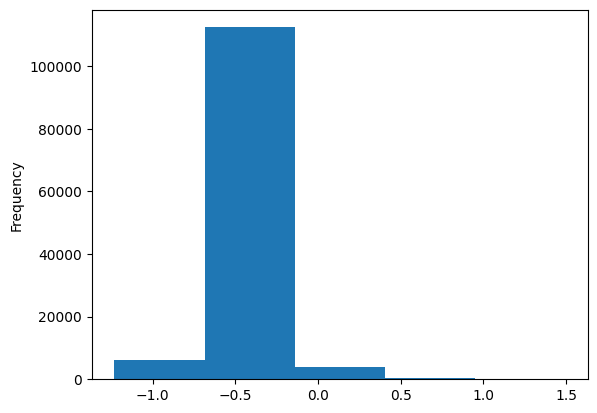

[(-1.2319999933242798, 5), (-0.6863499879837036, 73), (-0.14069998264312744, 365), (0.40495002269744873, 1250), (0.9506000280380249, 3012)]


In [190]:
# Method 1: allocate directly rwi to energy consumption
grid['rwi'].plot.hist(bins=5)
plt.show()
thresholds_rwi = (grid['rwi'].max()-grid['rwi'].min())/5*np.arange(5)+grid['rwi'].min()
table_rwi = list(zip(thresholds_rwi, thresholds_energy))
print(table_rwi)
grid['ResEnergyCorrPerHH_rwi'] = grid['rwi'].apply(lambda rwi: index_to_energy(rwi,table_rwi))

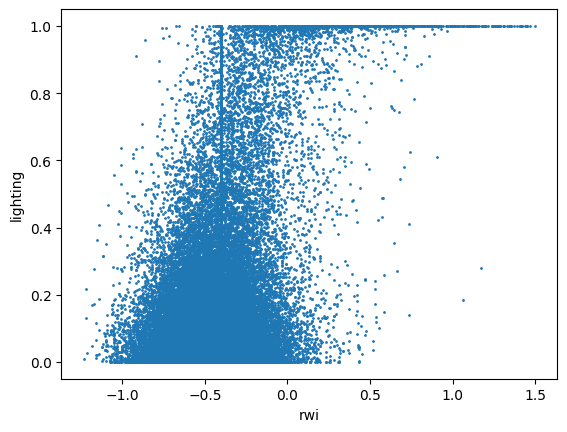

In [191]:
# Link between rwi and HREA
plt.scatter(grid['rwi'], grid['HREA'],s=1)

# Add labels to the plot
plt.xlabel('rwi')
plt.ylabel('lighting')

# Set the axis to logarithmic scale
# plt.yscale('log')
# plt.xscale('log')

# Show the plot
plt.show()

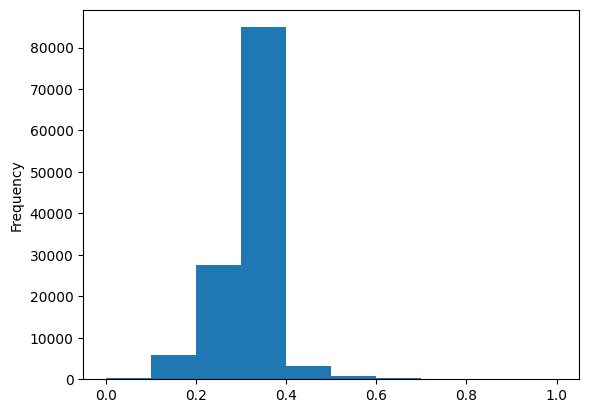

In [192]:
# Normalise the rwi index
rwi_min = grid['rwi'].min()
rwi_max = grid['rwi'].max()
grid['rwi_norm'] = (grid['rwi'] - rwi_min) / (rwi_max - rwi_min)
grid['rwi_norm'].plot.hist()
plt.show()

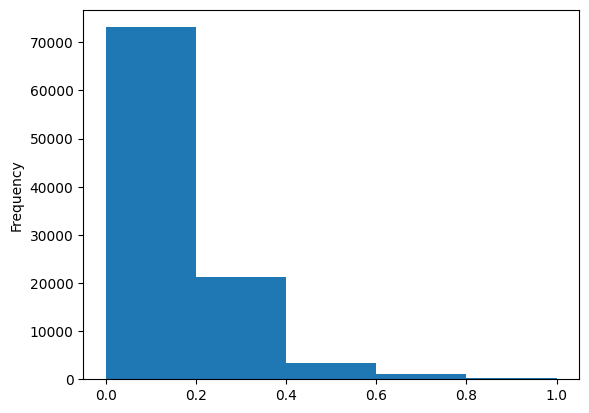

In [193]:
# Method 2: create an index combining rwi and HREA: geometric mean 
grid['index'] = np.power(grid['rwi_norm'] * grid['HREA'], 0.5)
grid['index'].plot.hist(bins=5)
thresholds_index = (grid['index'].max()-grid['index'].min())/5*np.arange(5)+grid['index'].min()
table_index = list(zip(thresholds_index, thresholds_energy))
plt.show()

ResEnergyCorrPerHH_index
5       73106
3012    24006
73      21287
365      3411
1250     1178
Name: count, dtype: int64


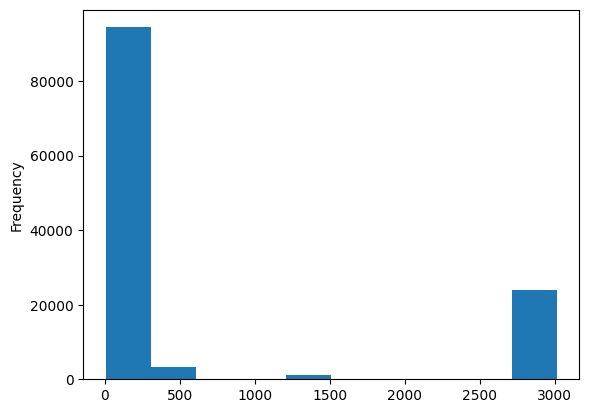

In [194]:
# allocate the energy consumption tier to the index
grid['ResEnergyCorrPerHH_index'] = grid['index'].apply(lambda index: index_to_energy(index,table_index))
grid['ResEnergyCorrPerHH_index'].plot.hist()
print(grid['ResEnergyCorrPerHH_index'].value_counts())
plt.show()

In [195]:
# Assess the shares of tier
tier_share = grid.groupby('ResEnergyCorrPerHH_index')['HHwithAccess'].sum()
tier_share.loc[0] = grid['HHwoAccess'].sum()
# print(tier_share)
print(tier_share/tier_share.sum())
# urban shares
tier_urban_share = grid.groupby('ResEnergyCorrPerHH_index')['HHwithAccess_urb'].sum()
tier_urban_share.loc[0] = grid['HHwoAccess_urb'].sum()
print(tier_urban_share/tier_urban_share.sum())
# rural shares
tier_rural_share = grid.groupby('ResEnergyCorrPerHH_index')['HHwithAccess_rur'].sum() 
tier_rural_share.loc[0] = grid['HHwoAccess_rur'].sum()
print(tier_rural_share/tier_rural_share.sum())

ResEnergyCorrPerHH_index
5      0.02
73     0.04
365    0.05
1250   0.16
3012   0.29
0      0.43
Name: HHwithAccess, dtype: float64
ResEnergyCorrPerHH_index
5      0.00
73     0.00
365    0.02
1250   0.29
3012   0.68
0      0.01
Name: HHwithAccess_urb, dtype: float64
ResEnergyCorrPerHH_index
5      0.04
73     0.07
365    0.07
1250   0.07
3012   0.01
0      0.75
Name: HHwithAccess_rur, dtype: float64


In [196]:
# Assess the energy Consumption assessment per cell
weightedRwi_norm = grid['rwi_norm'] * (grid ['HH_urban'] + grid ['HH_rural'])
averageRwi_norm = weightedRwi_norm.sum()/ (grid ['HH_urban'].sum() + grid ['HH_rural'].sum())
print(averageRwi_norm)
# grid["ResEnergyCorrPerHH"] = abs(grid['rwi']/averageRwi)*grid["ADM1_NAME"].map(energyConsHH)
grid["ResEnergyCorrPerHH"] = grid['ResEnergyCorrPerHH_index']
# grid["ResEnergyCorrPerHH"] = grid['ResEnergyCorrPerHH_index']*abs(grid['rwi_norm']/averageRwi_norm)
# grid["ResEnergyCorrPerHH"] = grid['ResEnergyCorrPerHH_rwi']*abs(grid['rwi']/averageRwi)
# grid["ResEnergyCorrPerHH"] = grid['ResEnergyCorrPerHH_rwi']

0.48611337015275885


### Step 3: assess energy consumption per cell

In [197]:
grid["ResEnergy_kWh"] = grid["HHwithAccess"] * grid["ResEnergyCorrPerHH"]

In [198]:
# assess total residential energy consumption
total_residentialenergy_assessed = grid["ResEnergy_kWh"].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh
total_residentialenergy_assessed = total_residentialenergy_assessed/10**6  # conversion in GWh

residential electricity consumption: 4,051 GWh


# Scale residential demand results

Get the electricity consumption at the national level for HH

In [199]:
energyBalance_path = "EnergyBalance/"
file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
eb = pd.read_csv(energyBalance_path + file_energyBalance)
code_elec = "B07_EL"
code_hh =  "B50_1231"
total_residentialenergy = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_hh) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_residentialenergy = pd.to_numeric(total_residentialenergy.str.replace(',', '')) # convert to numeric and remove commas
total_residentialenergy = total_residentialenergy.iloc[0]/3.6 # conversion in GWh
print("residential electricity consumption UN STATS:", f"{total_residentialenergy:,.0f}", "GWh")
print("residential electricity consumption assessed:", f"{total_residentialenergy_assessed:,.0f}", "GWh")

residential electricity consumption UN STATS: 4,022 GWh
residential electricity consumption assessed: 4,051 GWh


Compute total electricity consumption

In [200]:
total_residentialenergy_beforescaled = grid.groupby('NAME_1')['ResEnergy_kWh'].sum()
print ("Residential electricity consumption assessed before scaling:")
for region in regions:
    total_residentialenergy_beforescaled[region] = total_residentialenergy_beforescaled[region]/10**6  # conversion in GWh
    print (region, f"{total_residentialenergy_beforescaled[region]:,.1f}", "GWh" )
print (total_residentialenergy_beforescaled )

Residential electricity consumption assessed before scaling:
Copperbelt 1,297.7 GWh
Muchinga 38.5 GWh
North-Western 204.1 GWh
Western 97.9 GWh
Luapula 90.2 GWh
Northern 140.8 GWh
Central 252.1 GWh
Southern 303.8 GWh
Eastern 150.4 GWh
Lusaka 1,475.5 GWh
NAME_1
Central           252.12
Copperbelt      1,297.68
Eastern           150.36
Luapula            90.19
Lusaka          1,475.54
Muchinga           38.46
North-Western     204.08
Northern          140.78
Southern          303.81
Western            97.92
Name: ResEnergy_kWh, dtype: float64


In [201]:
# Scale previous results if area is country
scaling_factor = total_residentialenergy/total_residentialenergy_assessed
if area == "COUNTRY":
    print('{:.0%}'.format(scaling_factor))
    grid["REnS_kWh"] = grid["ResEnergy_kWh"] * scaling_factor
else:
    grid["REnS_kWh"] = grid["ResEnergy_kWh"]

99%


In [202]:
total_residentialenergy_scaled = grid.groupby('NAME_1')['REnS_kWh'].sum()   
print ("Residential electricity consumption assessed after scaling:")
for region in regions:
    total_residentialenergy_scaled[region] = total_residentialenergy_scaled[region]/10**6  # conversion in GWh
    print (region, f"{total_residentialenergy_scaled[region]:,.1f}", "GWh" )
print (total_residentialenergy_scaled )

Residential electricity consumption assessed after scaling:
Copperbelt 1,288.6 GWh
Muchinga 38.2 GWh
North-Western 202.6 GWh
Western 97.2 GWh
Luapula 89.6 GWh
Northern 139.8 GWh
Central 250.3 GWh
Southern 301.7 GWh
Eastern 149.3 GWh
Lusaka 1,465.2 GWh
NAME_1
Central           250.35
Copperbelt      1,288.58
Eastern           149.30
Luapula            89.56
Lusaka          1,465.18
Muchinga           38.19
North-Western     202.64
Northern          139.79
Southern          301.68
Western            97.24
Name: REnS_kWh, dtype: float64


In [203]:
grid.to_csv("data.csv")
grid.to_file(out_path + "\\" + 'res_energy_map.shp', index=False)
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,REnS_kWh,serBui,serBUi_Acc,SEn_kWh,HHwoAccess_urb,HHwoAccess_rur,res_urbanBui,res_ruralBui,res_Bui,ResEnergyCorrPerHH_rwi
0,8755a5318ffffff,24.24,-16.63,9.00,Western,1,9.00,0.00,0.03,-0.40,...,0.43,3.95,0.13,47.35,0.00,2.50,0.00,2.58,2.58,73
1,873980648ffffff,31.56,-8.83,7.00,Northern,2,44.00,0.00,0.04,-0.23,...,2.90,18.40,0.76,271.27,0.00,13.52,0.00,14.11,14.11,73
2,8755ac054ffffff,22.59,-16.09,9.00,Western,3,NaN,NaN,0.00,-0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73


# Services

Get the electricity consumption for services

In [204]:
# energyBalance_path = "EnergyBalance/"
# file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
# eb = pd.read_csv(energyBalance_path + file_energyBalance)
# code_elec = "B07_EL"
code_ser =  "B49_1235"
cod_oth = "B51_1234" # Other consumption not elsewhere specified in UN stats
total_servicesenergy = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_ser) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_servicesenergy = pd.to_numeric(total_servicesenergy.str.replace(',', '')) # convert to numeric and remove commas
total_servicesenergy = total_servicesenergy.iloc[0]/3.6 # conversion in GWh
print("services electricity consumption UN STATS:", f"{total_servicesenergy:,.0f}", "GWh")

services electricity consumption UN STATS: 722 GWh


In [205]:
# services building in each location
grid['serBui'] = grid['buildingssum'] - grid['res_Bui']
totalSerBui = grid['serBui'].sum()
totalSerBui
print(f"{totalSerBui:,.0f}", "services buildings")

4,746,425 services buildings


In [206]:
# energy consumption per building in services
grid['serBUi_Acc'] = grid['serBui'] * grid[columnProbElec]
totalSerBui_withAccess = grid['serBUi_Acc'].sum()
print("total services buildings with access:", f"{totalSerBui_withAccess:,.0f}")
ser_enBui = total_servicesenergy / totalSerBui_withAccess 
ser_enBui = ser_enBui *10**6 #conversion in kWh
print(f"{ser_enBui:,.0f}", "kWh per building")

total services buildings with access: 2,025,106
356 kWh per building


In [207]:
# compute services energy demand
grid['SEn_kWh'] = ser_enBui * grid['serBUi_Acc']

In [208]:
grid.to_csv("dataser.csv")
grid.to_file(out_path + "\\" + 'ser_energy_map.shp', index=False)
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,REnS_kWh,serBui,serBUi_Acc,SEn_kWh,HHwoAccess_urb,HHwoAccess_rur,res_urbanBui,res_ruralBui,res_Bui,ResEnergyCorrPerHH_rwi
0,8755a5318ffffff,24.24,-16.63,9.00,Western,1,9.00,0.00,0.03,-0.40,...,0.43,3.95,0.13,47.35,0.00,2.50,0.00,2.58,2.58,73
1,873980648ffffff,31.56,-8.83,7.00,Northern,2,44.00,0.00,0.04,-0.23,...,2.90,18.40,0.76,271.27,0.00,13.52,0.00,14.11,14.11,73
2,8755ac054ffffff,22.59,-16.09,9.00,Western,3,NaN,NaN,0.00,-0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73
